<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Define-Models" data-toc-modified-id="Define-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Models</a></span><ul class="toc-item"><li><span><a href="#CNN-1D" data-toc-modified-id="CNN-1D-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CNN 1D</a></span><ul class="toc-item"><li><span><a href="#single-step-forecasting" data-toc-modified-id="single-step-forecasting-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>single-step forecasting</a></span></li><li><span><a href="#Multi-step-forecasting" data-toc-modified-id="Multi-step-forecasting-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Multi-step forecasting</a></span></li></ul></li></ul></li></ul></div>

## Import libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['axes.grid'] = False

label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

Init Plugin
Init Graph Optimizer
Init Kernel


## Load Data

In [2]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

df = pd.read_csv(url,sep=",")

display(df.head())
display(df.tail())


,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


,Date,Consumption,Wind,Solar,Wind+Solar
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


In [3]:
df.isna().sum()

Date              0
Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
dtype: int64

In [4]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.set_index('Date')

In [5]:
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2012-01-01,948.12800,227.465,6.587,234.052
2012-01-02,1269.58100,207.327,6.574,213.901
2012-01-03,1334.74500,473.468,24.679,498.147
2012-01-04,1347.13600,499.804,14.681,514.485
2012-01-05,1376.65800,523.851,5.071,528.922
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


<AxesSubplot:xlabel='Date'>

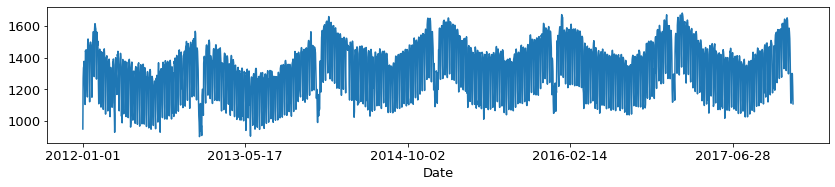

In [37]:
plt.figure(figsize=(14,2.5))
df['Consumption'].plot()

In [7]:
df['Consumption'].values

array([ 948.128  , 1269.581  , 1334.745  , ..., 1295.08753, 1215.44897,
       1107.11488])

In [8]:
input_width = 10 
label_width = 10 
shift = 1 
total_window_size = input_width + shift 


In [9]:
df['Consumption'][:input_width]


Date
2012-01-01     948.128
2012-01-02    1269.581
2012-01-03    1334.745
2012-01-04    1347.136
2012-01-05    1376.658
2012-01-06    1291.215
2012-01-07    1175.688
2012-01-08    1103.383
2012-01-09    1443.371
2012-01-10    1434.631
Name: Consumption, dtype: float64

In [10]:
df['Consumption'][total_window_size:total_window_size+input_width]

Date
2012-01-12    1442.448
2012-01-13    1403.402
2012-01-14    1203.165
2012-01-15    1150.920
2012-01-16    1487.782
2012-01-17    1518.074
2012-01-18    1498.809
2012-01-19    1470.066
2012-01-20    1448.554
2012-01-21    1242.307
Name: Consumption, dtype: float64

In [11]:
df['Consumption'][shift:label_width]

Date
2012-01-02    1269.581
2012-01-03    1334.745
2012-01-04    1347.136
2012-01-05    1376.658
2012-01-06    1291.215
2012-01-07    1175.688
2012-01-08    1103.383
2012-01-09    1443.371
2012-01-10    1434.631
Name: Consumption, dtype: float64

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

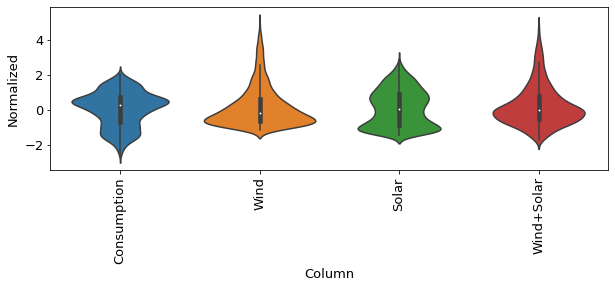

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 3))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [15]:
# univariate forecasting 

def create_dataset(input_width, label_width, shift, CONV_WIDTH=None):

    if CONV_WIDTH is not None: 
        input_width = label_width + (CONV_WIDTH - 1)
        shift = CONV_WIDTH
    
    
    total_window_size = input_width + shift 
    
    batch_size = 400

    i,count = 0, 0
    inputs, labels = [], []
    while count < batch_size: 
    #    print(i,i+input_width, " : ", i+shift,i+shift+label_width)
        inputs.append(train_df['Consumption'][i:i+input_width].values)
        labels.append(train_df['Consumption'][i+shift:i+shift+label_width].values)
        i+=shift
        count+=1

    inputs = np.array(inputs)[:,:,np.newaxis]
    labels = np.array(labels)[:,:,np.newaxis]

    input_indices = np.arange(0,input_width)
    label_indices = np.arange(shift, label_width+shift)

    print(inputs.shape)
    print(labels.shape)
    
    return inputs, labels, input_indices, label_indices


CONV_WIDTH = 3
inputs, labels, input_indices, label_indices = create_dataset(input_width=40, 
                                                              label_width=40, 
                                                              shift=1, 
                                                              CONV_WIDTH=CONV_WIDTH)


(400, 42, 1)
(400, 40, 1)


In [21]:
input_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

In [22]:
def plot(model=None, plot_col = 'Consumption'):
    
    plt.figure(figsize=(10, 6))
    max_n = 3
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col}')
    
        plt.plot(input_indices, inputs[n,:,0], 
                 label='Inputs', marker='.', zorder=-10)
        plt.scatter(label_indices, labels[n,:,0], 
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model: 
            predictions = model(inputs)
            plt.scatter(label_indices, predictions[n, :, 0],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

        
        if n == 0:
            plt.legend(bbox_to_anchor=(1., 1), loc='upper left', 
                       fontsize=13)

    plt.xlabel('Time [days]')


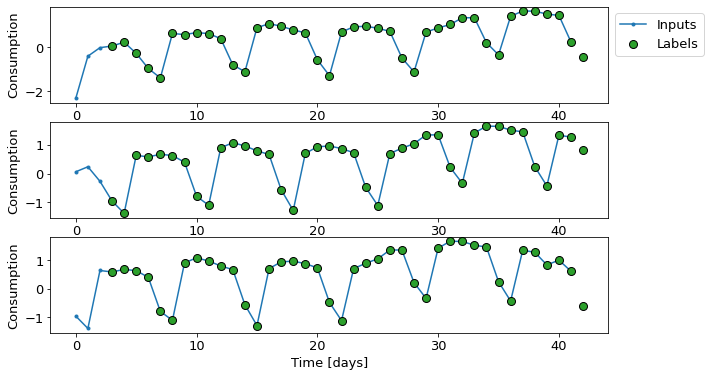

In [23]:
plot()

In [19]:
inputs.shape, labels.shape

((400, 42, 1), (400, 40, 1))

## Define Models

In [25]:
models={}

models['linear'] = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

models['dense'] = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

models['Conv1D'] = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


MAX_EPOCHS = 2000

def compile_and_fit(model, inputs, labels, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(inputs, labels, epochs=MAX_EPOCHS, 
                        validation_split=0.2, verbose=1, 
                        callbacks=[early_stopping])

    return history


Metal device set to: Apple M1


2021-09-02 13:06:31.540701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-02 13:06:31.541403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### CNN 1D 

#### single-step forecasting 

In [28]:
models['Conv1D'](inputs).shape

TensorShape([400, 40, 1])

In [29]:
history = compile_and_fit(models['Conv1D'], inputs, labels)

2021-09-02 13:06:58.707875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-02 13:06:58.710726: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-02 13:06:58.910504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/2000
10/10 [==============================] - 0s 19ms/step - loss: 1.0252 - mean_absolute_error: 0.7951 - val_loss: 1.0768 - val_mean_absolute_error: 0.9232
Epoch 2/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.8634 - mean_absolute_error: 0.7275 - val_loss: 0.9367 - val_mean_absolute_error: 0.8695
Epoch 3/2000
 1/10 [==>...........................] - ETA: 0s - loss: 0.7983 - mean_absolute_error: 0.6986

2021-09-02 13:06:59.162627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 11ms/step - loss: 0.7405 - mean_absolute_error: 0.6775 - val_loss: 0.8253 - val_mean_absolute_error: 0.8184
Epoch 4/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.6445 - mean_absolute_error: 0.6374 - val_loss: 0.7304 - val_mean_absolute_error: 0.7619
Epoch 5/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.5652 - mean_absolute_error: 0.5991 - val_loss: 0.6520 - val_mean_absolute_error: 0.6978
Epoch 6/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.5022 - mean_absolute_error: 0.5591 - val_loss: 0.5830 - val_mean_absolute_error: 0.6296
Epoch 7/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.4514 - mean_absolute_error: 0.5235 - val_loss: 0.5255 - val_mean_absolute_error: 0.5722
Epoch 8/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.4102 - mean_absolute_error: 0.4973 - val_loss: 0.4867 - val_mean_absolute_error: 0.5374
Epoch 9/2000
10/10 [====

10/10 [==============================] - 0s 11ms/step - loss: 0.2164 - mean_absolute_error: 0.3247 - val_loss: 0.1965 - val_mean_absolute_error: 0.2922
Epoch 53/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.2155 - mean_absolute_error: 0.3232 - val_loss: 0.1955 - val_mean_absolute_error: 0.2934
Epoch 54/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.2150 - mean_absolute_error: 0.3236 - val_loss: 0.1950 - val_mean_absolute_error: 0.2978
Epoch 55/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.2140 - mean_absolute_error: 0.3213 - val_loss: 0.1928 - val_mean_absolute_error: 0.2892
Epoch 56/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.2129 - mean_absolute_error: 0.3220 - val_loss: 0.1913 - val_mean_absolute_error: 0.2851
Epoch 57/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.2119 - mean_absolute_error: 0.3195 - val_loss: 0.1920 - val_mean_absolute_error: 0.2812
Epoch 58/2000
10/10

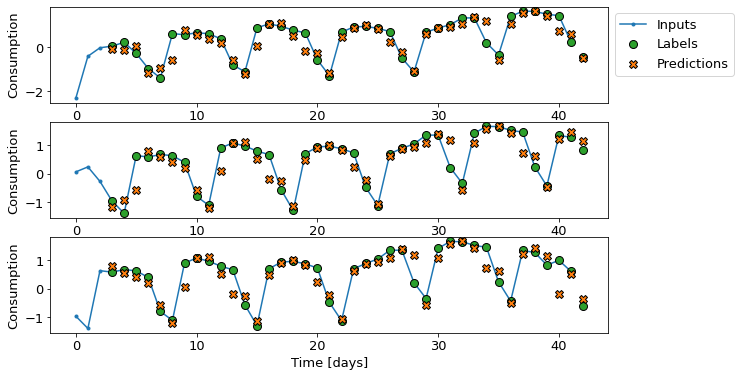

In [30]:
plot(models['Conv1D'])

#### Multi-step forecasting 

In [31]:
inputs, labels, input_indices, label_indices = create_dataset(input_width=40, 
                                                              label_width=40, 
                                                              shift=1)                 

(400, 40, 1)
(400, 40, 1)


In [32]:
num_features

4

In [33]:


lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])



In [34]:
lstm_model(inputs).shape

TensorShape([400, 40, 1])

In [35]:
history = compile_and_fit(lstm_model, inputs, labels)


Epoch 1/2000


2021-09-02 13:07:28.584341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-02 13:07:28.663954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-02 13:07:28.895047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - loss: 1.0250 - mean_absolute_error: 0.7693

2021-09-02 13:07:30.504651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-02 13:07:30.541614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 109ms/step - loss: 1.0115 - mean_absolute_error: 0.7658 - val_loss: 1.1873 - val_mean_absolute_error: 0.9318
Epoch 2/2000
10/10 [==============================] - 0s 50ms/step - loss: 0.8349 - mean_absolute_error: 0.7390 - val_loss: 1.1221 - val_mean_absolute_error: 0.9209
Epoch 3/2000
10/10 [==============================] - 0s 49ms/step - loss: 0.7893 - mean_absolute_error: 0.7789 - val_loss: 1.0965 - val_mean_absolute_error: 0.9101
Epoch 4/2000
10/10 [==============================] - 0s 49ms/step - loss: 0.7696 - mean_absolute_error: 0.7555 - val_loss: 1.0536 - val_mean_absolute_error: 0.8888
Epoch 5/2000
10/10 [==============================] - 0s 48ms/step - loss: 0.7577 - mean_absolute_error: 0.7401 - val_loss: 1.0566 - val_mean_absolute_error: 0.8833
Epoch 6/2000
10/10 [==============================] - 0s 49ms/step - loss: 0.7446 - mean_absolute_error: 0.7438 - val_loss: 1.0705 - val_mean_absolute_error: 0.8822


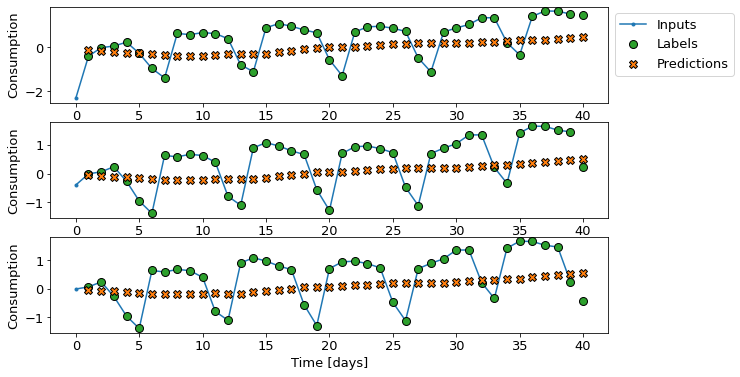

In [36]:
plot(lstm_model)